<h1><center> IR System using Pre-trained model (Simple Transformers) </center></h1>

In [1]:
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --user pandas==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 69.9 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# downloaded1 = drive.CreateFile({'id':"1eAyT999RWo64LMOW89-H5S3RCUwVl-BU"})   # id of file you want to access
# downloaded1.GetContentFile('squad.json')
# downloaded2 = drive.CreateFile({'id':"1VoNX3rqw3KXpPYnH0x45prtSq8qH3KpS"})   # id of file you want to access
# downloaded2.GetContentFile('train1.json')
# downloaded3 = drive.CreateFile({'id':"1uEABHi4YEZ3sD3OqOpdGNxeEaMv1S7DK"})   # id of file you want to access
# downloaded3.GetContentFile('dev1.json')

**Import Libraries**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from pandas.io.json import json_normalize


**Load the dataset**

In [8]:
# squad = pd.read_json('squad.json')
train = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Squad/train-v2.0.json')
dev = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Squad/dev-v2.0.json')

In [9]:
# squad.head()

In [10]:
# print("Shape of data =",squad.shape)

In [11]:
train.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [12]:
print("Shape of data =",train.shape)

Shape of data = (442, 2)


In [13]:
dev.head()

,version,data
0,v2.0,"{'title': 'Normans', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Computational_complexity_theory', '..."
2,v2.0,"{'title': 'Southern_California', 'paragraphs':..."
3,v2.0,"{'title': 'Sky_(United_Kingdom)', 'paragraphs'..."
4,v2.0,"{'title': 'Victoria_(Australia)', 'paragraphs'..."


In [14]:
print("Shape of dev data =", dev.shape)

Shape of dev data = (35, 2)


Put dev file in a dataframe to be readable

In [15]:
#This has multiple answers for same questions unlike traing data
def dtodf(dfile, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    #dfile: path to the squad json file.
    #record_path: path to deepest level in json fil
  
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(dfile).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [16]:
dfile = '/content/drive/MyDrive/Colab Notebooks/Squad/dev-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev1 = dtodf(dfile=dfile,record_path=record_path)

Reading the json file
processing...


<ipython-input-15-9fc060acdb7f>:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  js = pd.io.json.json_normalize(file , record_path )
<ipython-input-15-9fc060acdb7f>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  m = pd.io.json.json_normalize(file, record_path[:-1] )
<ipython-input-15-9fc060acdb7f>:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  r = pd.io.json.json_normalize(file,record_path[:-2])


shape of the dataframe is (11873, 5)
Done


In [17]:
dev1.head

<bound method NDFrame.head of                              id  \
0      56ddde6b9a695914005b9628   
1      56ddde6b9a695914005b9629   
2      56ddde6b9a695914005b962a   
3      56ddde6b9a695914005b962b   
4      56ddde6b9a695914005b962c   
...                         ...   
11868  5737aafd1c456719005744ff   
11869  5ad28ad0d7d075001a4299cc   
11870  5ad28ad0d7d075001a4299cd   
11871  5ad28ad0d7d075001a4299ce   
11872  5ad28ad0d7d075001a4299cf   

                                                question  \
0                   In what country is Normandy located?   
1                     When were the Normans in Normandy?   
2          From which countries did the Norse originate?   
3                              Who was the Norse leader?   
4      What century did the Normans first gain their ...   
...                                                  ...   
11868  What is the seldom used force unit equal to on...   
11869           What does not have a metric counterpart?   
11870  Wh

**Put the training json file into a dataframe**

In [18]:
def ttodf(dfile, record_path = ['data','paragraphs','qas','answers'], verbose = 1):
    #dfile: path to the squad json file.
    #record_path: path to last level in the json file
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(dfile).read())
    if verbose:
        print("processing...")
    # parsing different levels in the json file
    js = pd.json_normalize(file , record_path )
    m = pd.json_normalize(file, record_path[:-1] )
    r = pd.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("Done")
    return main

In [19]:
dfile = '/content/drive/MyDrive/Colab Notebooks/Squad/train-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
train1 = ttodf(dfile=dfile,record_path=record_path)

Reading the json file
processing...


<ipython-input-18-8b849ba60f82>:19: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()


Done


**Checking Structure of the dataset**

In [20]:
train1.head()

,index,question,context,text,answer_start,c_id
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166.0,0
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276.0,0



**Text Data Pre-processing**

Data dimensions

In [21]:
print("Shape of data =", train1.shape)
#the dataset contains 87599 rows and 6 columns, we drop the columns that are not needed

Shape of data = (130319, 6)


Checking for Null values

In [22]:
train1.isnull().sum()
#no null values

index               0
question            0
context             0
text            43498
answer_start    43498
c_id                0
dtype: int64

In [23]:
#take a look at the text present in the columns
train1['question'].unique()

array(['When did Beyonce start becoming popular?',
       'What areas did Beyonce compete in when she was growing up?',
       "When did Beyonce leave Destiny's Child and become a solo singer?",
       ..., 'What is another name for anti-matter?',
       'Matter usually does not need to be used in conjunction with what?',
       'What field of study has a variety of unusual contexts?'],
      dtype=object)

In [24]:
train1['context'].unique()

array(['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
       'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and

In [25]:
train1['text'].unique()

array(['in the late 1990s', 'singing and dancing', '2003', ..., 'Oregon',
       'Minsk', 'Kathmandu Metropolitan City'], dtype=object)

**Cleaning Text Data for word embeddings**

When cleaning the text, we will perform the following task

1.   Convert text to lowercase
2.   Remove punctuations
3.   Remove extra space



1. Convert text to lowercase (because in NLP casing matters)


In [26]:
train1['clean_question']=train1['question'].apply(lambda x: x.lower() if isinstance(x, str) else str(x))
train1['clean_context']=train1['context'].apply(lambda x: x.lower() if isinstance(x, str) else str(x))
train1['clean_text']=train1['text'].apply(lambda x: x.lower() if isinstance(x, str) else str(x))

2. Removing punctuations

In [27]:
import re
import string
train1['clean_question']=train1['clean_question'].str.replace('[^\w\s]','')
train1['clean_context']=train1['clean_context'].str.replace('[^\w\s]','')
train1['clean_text']=train1['clean_text'].str.replace('[^\w\s]','')

<ipython-input-27-3e5e0fdaaa50>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train1['clean_question']=train1['clean_question'].str.replace('[^\w\s]','')
<ipython-input-27-3e5e0fdaaa50>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train1['clean_context']=train1['clean_context'].str.replace('[^\w\s]','')
<ipython-input-27-3e5e0fdaaa50>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train1['clean_text']=train1['clean_text'].str.replace('[^\w\s]','')


3. Removing extra space

In [28]:
train1['clean_question']=train1['clean_question'].apply(lambda x: re.sub(' +',' ',x) )
train1['clean_context']=train1['clean_context'].apply(lambda x: re.sub(' +',' ',x))
train1['clean_text']=train1['clean_text'].apply(lambda x: re.sub(' +',' ',x))

Checking

In [29]:
train1['clean_question'].unique()

array(['when did beyonce start becoming popular',
       'what areas did beyonce compete in when she was growing up',
       'when did beyonce leave destinys child and become a solo singer',
       ..., 'what is another name for antimatter',
       'matter usually does not need to be used in conjunction with what',
       'what field of study has a variety of unusual contexts'],
      dtype=object)

In [30]:
train1['clean_context'].unique()

array(['beyoncé giselle knowlescarter biːˈjɒnseɪ beeyonsay born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destinys child managed by her father mathew knowles the group became one of the worlds bestselling girl groups of all time their hiatus saw the release of beyoncés debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy',
       'following the disbandment of destinys child in june 2005 she released her second solo album bday 2006 which contained hits déjà vu irreplaceable and beautiful liar beyoncé also ventured into acting with a golden globenominated performance in dreamgirls 2006 and starring roles in the pink panther 2006 and obsessed 2009 her 

In [31]:
train1['clean_text'].unique()

array(['in the late 1990s', 'singing and dancing', '2003', ..., 'oregon',
       'minsk', 'kathmandu metropolitan city'], dtype=object)

Statistically checking the data

In [32]:
train1['clean_question'].describe()

count                                  130319
unique                                 130174
top       in what year did world war ii start
freq                                        3
Name: clean_question, dtype: object

In [33]:
train1['clean_context'].describe()

count                                                130319
unique                                                19027
top       in 1853 victoria gave birth to her eighth chil...
freq                                                     30
Name: clean_context, dtype: object

In [34]:
train1['clean_text'].describe().head()

count     130319
unique     62918
top          nan
freq       43498
Name: clean_text, dtype: object

In [35]:
#dropping columns
train1 = train1.drop(train1.columns[[0, 1, 2, 4, 5]], axis=1) 

In [36]:
train1.head()

,text,clean_question,clean_context,clean_text
0,in the late 1990s,when did beyonce start becoming popular,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,in the late 1990s
1,singing and dancing,what areas did beyonce compete in when she was...,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,singing and dancing
2,2003,when did beyonce leave destinys child and beco...,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,2003
3,"Houston, Texas",in what city and state did beyonce grow up,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,houston texas
4,late 1990s,in which decade did beyonce become famous,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,late 1990s


In [37]:
print(train1.loc[[0]])

                text                           clean_question  \
0  in the late 1990s  when did beyonce start becoming popular   

                                       clean_context         clean_text  
0  beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...  in the late 1990s  


**Wordcloud**

In [38]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys

Wordcloud for Questions 

In [40]:
wordcloud1 = WordCloud().generate(' '.join(train1['clean_question']))

In [41]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies(self, frequencies, max_font_size=None)>

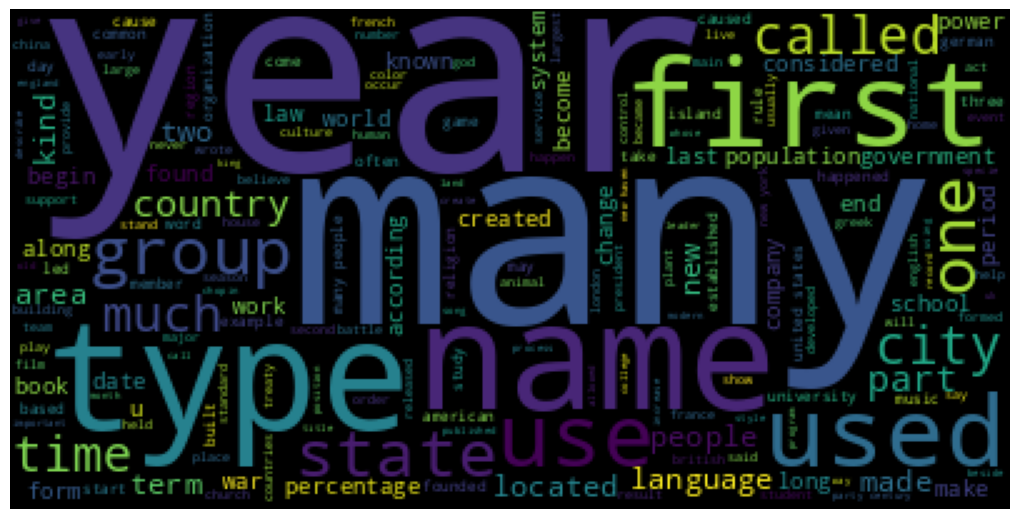

In [42]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Wordcloud for Contexts 

In [43]:
wordcloud2 = WordCloud().generate(' '.join(train1['clean_context']))

In [44]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies(self, frequencies, max_font_size=None)>

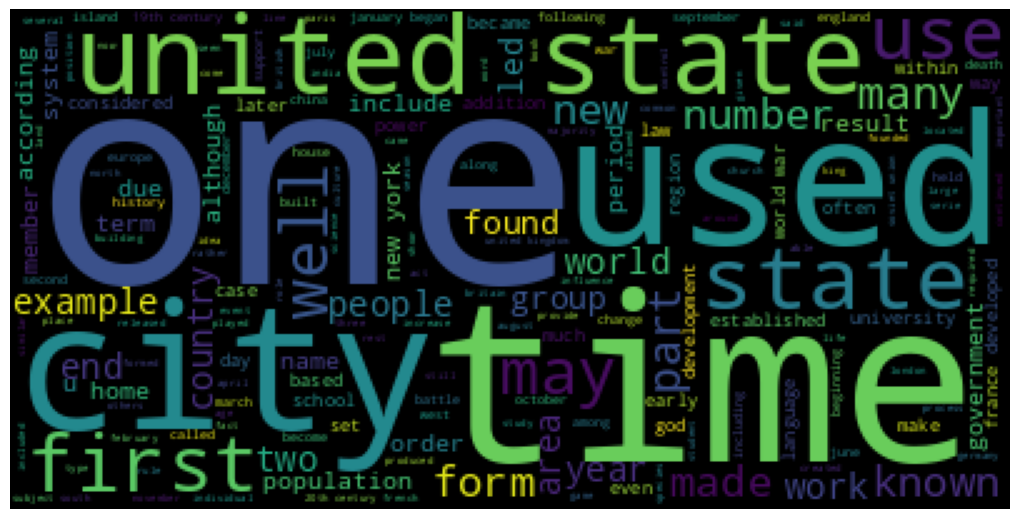

In [45]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Wordcloud for Answers

In [46]:
wordcloud3 = WordCloud().generate(' '.join(train1['clean_text']) )

In [47]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies(self, frequencies, max_font_size=None)>

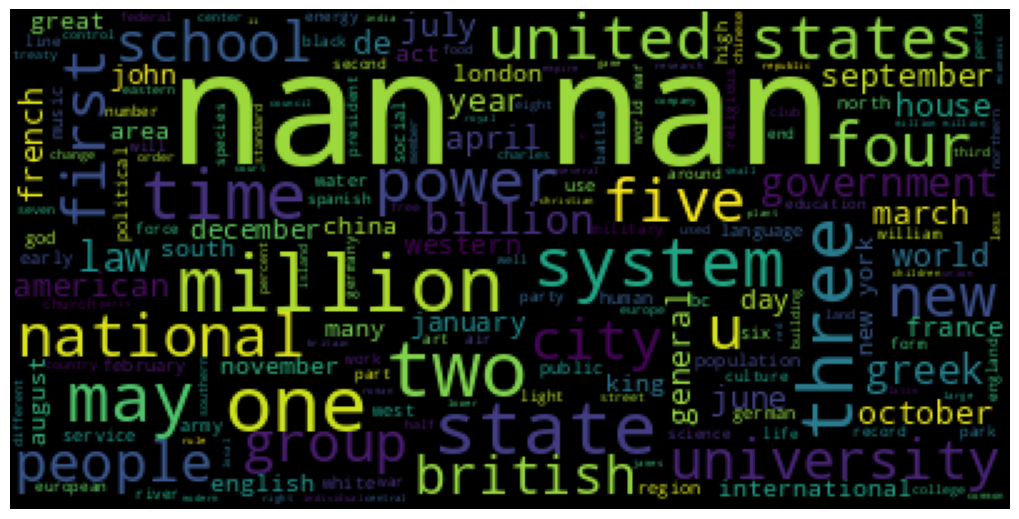

In [48]:
plt.figure(figsize = (10, 10), facecolor = None ) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

**Word Embeddings**

Using word2vec for word embeddings:

using pretrained word embedding vector because of sparsity of training data and large no of parameters


In [49]:
import os
import nltk
import gensim
#training the model using Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
import multiprocessing

from gensim.models import Word2Vec

#making the columns as list of words for input
list_context = [row.split() for row in train1['clean_context']]
list_question = [row.split() for row in train1['clean_question']]
list_text = [row.split() for row in train1['clean_text']]

In [50]:
type(list_context)
type(list_question)
type(list_text)

list

In [55]:
#Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_context = Word2Vec(min_count=1,
                     window=2,
                    vector_size = 32,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)


In [56]:
#building vocab table for context
w2v_context.build_vocab(list_context, progress_per=10000)
print(w2v_context)

Word2Vec<vocab=97407, vector_size=32, alpha=0.03>


In [57]:
#training
w2v_context.train(list_context, 
                  total_examples=w2v_context.corpus_count,
                  epochs=30, 
                  report_delay=1)

(262222155, 467144340)

In [58]:
#replace is set at false to forget original vectors and only keep normalized to save memeory
w2v_context.init_sims(replace=True)

<ipython-input-58-1f46373cfac3>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_context.init_sims(replace=True)


In [59]:
#exploring
w2v_context.wv.most_similar(positive=["york"])

[('jersey', 0.8442513942718506),
 ('boston', 0.840412974357605),
 ('philadelphia', 0.8329412341117859),
 ('haven', 0.8264084458351135),
 ('city', 0.78851318359375),
 ('london', 0.7802414894104004),
 ('oklahoma', 0.7602579593658447),
 ('melbourne', 0.7588202357292175),
 ('charleston', 0.7506276369094849),
 ('miami', 0.7397298812866211)]

In [60]:
#to see how similar words are to each other
w2v_context.wv.similarity('genocide', 'who')

0.2564221

In [61]:
#odd one out
w2v_context.wv.doesnt_match(['catholic', 'new', 'york'])

'catholic'

In [63]:
# context_vocabsize=len(w2v_context.wv.vocab)
# context_vocabsize

In [65]:
#Word2Vec
w2v_question= Word2Vec(min_count=1,
                     window=2,
                     vector_size=32,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [66]:
#building vocab table for question
w2v_question.build_vocab(list_question, progress_per=10000)

In [67]:
#training
w2v_question.train(list_question, total_examples=w2v_question.corpus_count, epochs=30, report_delay=1)

(18763959, 38652900)

In [68]:
#replace is set at false to forget original vectors and only keep normalized to save memeory
w2v_question.init_sims(replace=True)

<ipython-input-68-5bb82b9fe6ca>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_question.init_sims(replace=True)


In [69]:
#exploring the model
w2v_question.wv.most_similar(positive=["many"])

[('how', 0.9388092160224915),
 ('were', 0.7859781384468079),
 ('approximately', 0.7836378216743469),
 ('six', 0.7566441297531128),
 ('there', 0.7545849680900574),
 ('four', 0.7464110851287842),
 ('are', 0.738137423992157),
 ('millions', 0.7380744218826294),
 ('thousands', 0.7262988686561584),
 ('nine', 0.7222387790679932)]

In [70]:
#to see how similar words are to each other
w2v_question.wv.similarity('what', 'who')

0.21170785

In [71]:
#odd one out
w2v_question.wv.doesnt_match(['catholic', 'church', 'york'])

'york'

In [73]:
# question_vocabsize=len(w2v_question.wv.vocab)
# question_vocabsize

Transfer learning


In [75]:
#using pre-trained transformer models using the simple transformers library from the huggingface transformers https://github.com/huggingface/transformers 
!pip install wandb
!pip install transformers
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers 

from simpletransformers.question_answering import QuestionAnsweringModel


train_args = {
    'learning_rate': 3e-5,
    'num_train_epochs': 2,
    'max_seq_length': 384,
    'doc_stride': 128,
    'overwrite_output_dir': True,
    'reprocess_input_data': False,
    'train_batch_size': 2,
    'gradient_accumulation_steps': 8,
}

model = QuestionAnsweringModel('bert', 'bert-base-cased', args=train_args)
#bert is model type and bert-base-cased is the model name



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

ValueError: ignored

In [ ]:
#converting the json files to list of dictionary which is the suitable format to perform QA in simple transformers
train = [item for topic in train['data'] for item in topic['paragraphs'] ]

type(train)

In [ ]:
len(train)

In [ ]:
#getting a random sample for training
import random
random.seed(3)
randomtrain=random.sample(train, 5000)


In [ ]:
len(randomtrain)

In [ ]:
remain = [ele for ele in train if ele not in randomtrain]
len(remain) 

In [ ]:
#getting a random sample for testing
random.seed(6)
randomtest=random.sample(remain, 1000)

In [ ]:
import sklearn
model.train_model(randomtrain, acc=sklearn.metrics.accuracy_score)


In [ ]:
import pickle
model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Squad/model.pkl', 'rb'))

Evaluation

In [ ]:
import sklearn
result, text= model.eval_model(randomtest, acc=sklearn.metrics.accuracy_score, verbose= True)
print(result)#contains evaluation result
print(text)#a dict containing the the correct_text, similar_text and incorrect text

add example index and unique id: 100%|██████████| 6857/6857 [00:00<00:00, 608118.21it/s]


Running Evaluation:   0%|          | 0/864 [00:00<?, ?it/s]

{'correct': 4000, 'similar': 2431, 'incorrect': 426, 'acc': 0.5833454863642993, 'eval_loss': -7.502771448206018}
{'correct_text': {'5731e624e17f3d1400422519': '1936', '5731e624e17f3d140042251a': 'Talaat Harb', '5731e624e17f3d140042251c': 'three quarters', '572805f84b864d190016425e': '150', '572805f84b864d190016425f': 'The Computer and the Brain', '57326c5ae99e3014001e6795': '1974', '57326c5ae99e3014001e6797': 'New York Times', '57326c5ae99e3014001e6798': 'Edwin Pagan', '56de6a2e4396321400ee28ae': '1938', '56de6a2e4396321400ee28af': 'RCA', '5a83215fe60761001a2eb425': '', '5a83215fe60761001a2eb426': '', '5726dad6708984140094d3ac': 'two and a half months', '5726dad6708984140094d3ad': 'two and a half months', '5ad28656d7d075001a4298dc': '', '5ad28656d7d075001a4298dd': '', '5ad28656d7d075001a4298df': '', '5ad28656d7d075001a4298e0': '', '57309103069b531400832191': 'air traffic control', '5a4e914a755ab9001a10f4fb': '', '5a4e914a755ab9001a10f4fc': '', '5a4e914a755ab9001a10f4fd': '', '5a4e914a7

Prediction

In [ ]:
import sklearn
dev = [item for topic in dev['data'] for item in topic['paragraphs'] ]
predtn1, raw_outputs = model.predict(dev, n_best_size=2)#return a list of dict containg each question mapped to its answer and a list of dicts of question id mapped to probability score of the answer

predtn1[0]



add example index and unique id: 100%|██████████| 11873/11873 [00:00<00:00, 685360.39it/s]


Running Prediction:   0%|          | 0/1540 [00:00<?, ?it/s]

{'id': '56ddde6b9a695914005b9628', 'answer': ['France']}

In [ ]:
raw_outputs[0]

{'id': '56ddde6b9a695914005b9628', 'probability': [0.9999629470302284]}

In [ ]:
context_text = "Linear regression is used for predicting quantitative values, such as an individual’s salary. In order to predict qualitative values, such as whether a patient survives or dies, or whether the stock market increases or decreases, Fisher proposed linear discriminant analysis in 1936."
predtn2, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "Who proposed linear discriminant analysis?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(predtn2)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['Fisher']}]
[{'id': '0', 'probability': [0.9063219973254493]}]


In [ ]:
context_text = "Thomas Alva Edison was an American inventor and businessman who has been described as America's greatest inventor.One of his inventions, is the phonograph"
predtn3, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "Who invented phonograph?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(predtn3)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['Thomas Alva Edison']}]
[{'id': '0', 'probability': [0.9999271013245725]}]


In [ ]:
context_text = "Mary drove for 3 hours to work in the morning and 5 hours in the evening to her house"
predtn4, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "How many hours did Mary drive for today?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7612.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(predtn4)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['3', '3 hours to work in the morning and 5']}]
[{'id': '0', 'probability': [0.8082874890362919, 0.1912366274631815]}]
